In [1]:
# Step 1: Import Necessary Libraries
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import torchvision.transforms as T
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
# Step 2: Define Utility Functions
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [3]:
#Set Device and Model Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = 'bisenet_model.pth'

cuda


In [4]:
#Specify Paths and Configuration
image_path = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic"
mask_path = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask"

In [5]:
#Load and Preprocess Data for Visualization
names2 = ['X_mask_190','X_mask_191','X_mask_192']
names = ['X_seismic_190','X_seismic_191','X_seismic_192']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names2]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

In [7]:
x.shape

torch.Size([3, 1, 369, 496])

In [8]:
y.shape

torch.Size([3, 1, 369, 496])

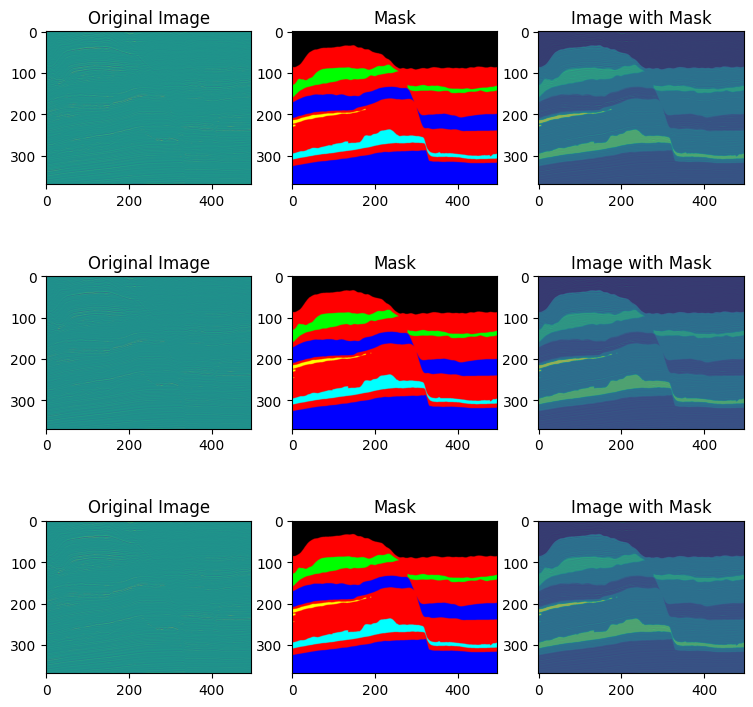

In [9]:
# Step 6: Visualize Sample Data
fig = plt.figure(figsize=(9, 9))
num_images = len(images)
for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(images[i])
    ax.set_title("Original Image")

    ax = fig.add_subplot(num_images, 3, i*3+2)
    ax.imshow(masks[i])
    ax.set_title("Mask")

    ax = fig.add_subplot(num_images, 3, i*3+3)
    ax.imshow(x[i].squeeze())
    ax.imshow(y[i].squeeze(), alpha=0.5)
    ax.set_title("Image with Mask")

plt.show()

In [10]:
# Step 7: Define Custom Dataset Class
class SegmentDataset(Dataset):

    color_encoding = [
                ('a', (0, 0, 0)),    # Black
                ('b', (255, 0, 0)),  # Red
                ('c', (0, 255, 0)),  # Green
                ('d', (0, 0, 255)),  # Blue
                ('e', (255, 255, 0)),  # Yellow
                ('f', (0, 255, 255))   # Cyan
    ]

    def __init__(self, image_paths, mask_paths, num_classes=7):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.num_classes=num_classes

#         self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])
        self.transforms = T.Compose([T.ToTensor()])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.convert('RGB')
        
        image = self.transforms(image)
        resized_image = T.Resize((104, 104))(image)
        
        mask = Image.open(self.mask_paths[idx])
        mask = mask.convert('RGB')
        mask = np.array(mask)
        mask = self.label_for_cross_entropy(mask)
        mask = Image.fromarray(mask)
        resized_mask = T.Resize((104, 104))(mask)
        resized_mask = np.array(resized_mask)
        
        return resized_image, torch.from_numpy(resized_mask).long()

    def label_for_cross_entropy(self, label):
        """
            Convert label image to matrix classes for apply cross entropy loss.
            Return semantic index, label in enumemap of H x W x class
        """
        semantic_map = np.zeros(label.shape[:-1])
        # Fill all value with class 13 - default for all pixels
        semantic_map.fill(self.num_classes - 1)
        # Fill the pixel with correct class

        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index
        return semantic_map

    def __len__(self):
        return len(self.mask_paths)

In [11]:
import os
from sklearn.model_selection import train_test_split

# Paths to your image and mask folders
image_folder = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic"
mask_folder = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask"

# List all files in the image and mask folders
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
mask_files = [os.path.join(mask_folder, file).replace('seismic', 'mask') for file in image_files]

# Split files into training and validation sets
image_train, image_val, mask_train, mask_val = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Verify the lengths of the training and validation sets
print(f"Number of training samples: {len(image_train)}")
print(f"Number of validation samples: {len(image_val)}")

# Optionally, you can create separate lists for training and validation images and masks
training_image_paths = image_train
training_mask_paths = mask_train
val_image_paths = image_val
val_mask_paths = mask_val

/home/sang/Desktop/venv39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of training samples: 625
Number of validation samples: 157


In [12]:
image_train

['/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_167.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_188.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_75.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_262.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_239.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_364.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_261.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_438.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_745.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_56.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_218.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_208.png',
 '/home/sang/Documents/Dataset/SEG_2020/ex

In [13]:
training_mask_paths

['/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_167.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_188.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_75.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_262.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_239.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_364.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_261.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_438.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_745.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_56.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_218.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_208.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_332.png',
 '/home/sang/Documents/Dataset/SEG_2020/

In [14]:
# Step 8: Initialize Dataset
train_dataset = SegmentDataset(training_image_paths, training_mask_paths)
# Step 5: Validation Dataset
val_dataset = SegmentDataset(val_image_paths, val_mask_paths)

In [15]:
# Step 6: Validation DataLoader
BATCH_SIZE = 64
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

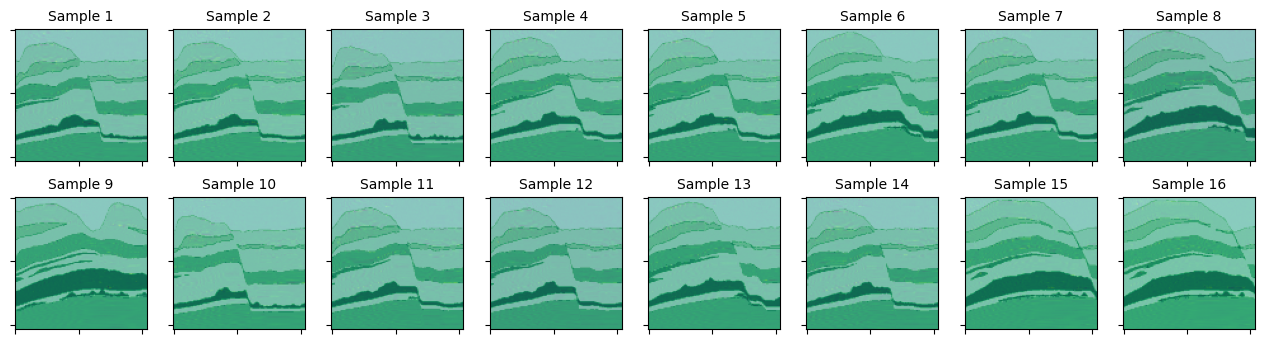

In [16]:

# Step 9: Visualize More Data from Dataset
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, mask = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

# # Add color bar to indicate mask colors
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
# cbar = plt.colorbar(cm.ScalarMappable(cmap='Greens'), cax=cax)
# cbar.set_label('Mask Colors')

plt.show()

In [17]:
# Step 10: Define Model Architecture

"""
This class defines a convolutional block, which consists of a convolutional layer followed by batch normalization.
"""
class ConvBlock(nn.Module):
    def __init__(self, in_channels, filters, size, stride=1, activation=True):
        super(ConvBlock, self).__init__()
        self.activation = activation
        # Convolutional layer with specified parameters
        self.conv = nn.Conv2d(in_channels, filters, size, stride=stride, padding=size // 2)
        # Batch normalization layer
        self.norm = nn.BatchNorm2d(filters)

    def forward(self, x):
        # Forward pass through the convolutional block
        x = self.conv(x)  # Apply convolution
        x = self.norm(x)  # Apply batch normalization
        if self.activation:
            return F.relu(x)  # Apply ReLU activation if specified
        else:
            return x


"""
This class defines a residual block, which consists of two convolutional blocks and optional residual connections.
"""
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, filters, size=3):
        super(ResidualBlock, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        # First convolutional block
        self.conv1 = ConvBlock(in_channels, filters, size)
        # Second convolutional block with no activation
        self.conv2 = ConvBlock(filters, filters, size, activation=False)

    def forward(self, x):
        residual = x  # Save input as residual
        x = F.relu(x)  # Apply ReLU activation
        x = self.norm(x)  # Apply batch normalization
        x = self.conv1(x)  # First convolutional block
        x = self.conv2(x)  # Second convolutional block
        # Optionally add residual connection
        # x += residual  # Uncomment if you want to use residual connections
        return x


"""
This class defines a deconvolutional block, which consists of a transposed convolutional layer.
"""
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super(DeconvBlock, self).__init__()
        # Transposed convolutional layer
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride)

    def forward(self, x1, x2):
        xd = self.deconv(x1)  # Apply transposed convolution
        # Concatenate feature maps from the transposed convolution with feature maps from a previous stage
        x = torch.cat([xd, x2], dim=1)
        return x
    
"""
Defines ChannelAttention class
"""
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_rate=16):
        super(ChannelAttention, self).__init__()
        self.squeeze = nn.ModuleList([
            nn.AdaptiveAvgPool2d(1),
            nn.AdaptiveMaxPool2d(1)
        ])
        
        self.excitation = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=channels // reduction_rate,
                      kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels // reduction_rate,
                      out_channels=channels,
                      kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # perform squeeze with independent Pooling
        avg_feat = self.squeeze[0](x)
        max_feat = self.squeeze[1](x)
        # perform excitation with the same excitation sub-net
        avg_out = self.excitation(avg_feat)
        max_out = self.excitation(max_feat)
        # attention
        attention = self.sigmoid(avg_out + max_out)
        return attention * x

In [33]:
# Step 11: Define U-Net Model
class UnetModel(nn.Module):

    def __init__(self, filters=16, dropout=0.5, num_classes=7, in_channel=1):
        super(UnetModel, self).__init__()
        # Define encoder layers
        self.num_classes=num_classes
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, filters, 3, padding=1),
            ResidualBlock(filters, filters),
            ResidualBlock(filters, filters),
            nn.ReLU()
        )
        
        # create channel attention
        self.attention_1 = ChannelAttention(filters)
        
        self.conv2 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, filters * 2, 3, padding=1),
            ResidualBlock(filters * 2, filters * 2),
            ResidualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )
        
        # create channel attention
        self.attention_2 = ChannelAttention(filters * 2)
        
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters * 4, 3, padding=1),
            ResidualBlock(filters * 4, filters * 4),
            ResidualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        # create channel attention
        self.attention_3 = ChannelAttention(filters * 4)
        
        self.conv4 = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 8, 3, padding=1),
            ResidualBlock(filters * 8, filters * 8),
            ResidualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
        
        # create channel attention
        self.attention_4 = ChannelAttention(filters * 8)
        
        # Define middle layers
        self.middle = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 16, 3, padding=3//2),
            ResidualBlock(filters * 16, filters * 16),
            ResidualBlock(filters * 16, filters * 16),
            nn.ReLU()
        )
        
        self.attention_5 = ChannelAttention(filters * 16)
        
        # Define decoder layers
        self.deconv4 = DeconvBlock(filters * 16, filters * 8, 3)
        self.upconv4 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 16, filters * 8, 3, padding=1),
            ResidualBlock(filters * 8, filters * 8),
            ResidualBlock(filters * 8, filters * 8),
            nn.ReLU()
        )
        
        self.attention_6 = ChannelAttention(filters * 8)
        
        self.deconv3 = DeconvBlock(filters * 8, filters * 4, 2)
        self.upconv3 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 8, filters * 4, 3, padding=1),
            ResidualBlock(filters * 4, filters * 4),
            ResidualBlock(filters * 4, filters * 4),
            nn.ReLU()
        )
        
        self.attention_7 = ChannelAttention(filters * 4)
        
        self.deconv2 = DeconvBlock(filters * 4, filters * 2, 2)
        self.upconv2 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 4, filters * 2, 3, padding=1),
            ResidualBlock(filters * 2, filters * 2),
            ResidualBlock(filters * 2, filters * 2),
            nn.ReLU()
        )
        
        self.attention_8 = ChannelAttention(filters * 2)
        
        self.deconv1 = DeconvBlock(filters * 2, filters, 2)
        self.upconv1 = nn.Sequential(
            nn.Dropout(dropout),
            nn.Conv2d(filters * 2, filters, 3, padding=1),
            ResidualBlock(filters, filters),
            ResidualBlock(filters, filters),
            nn.ReLU(),
            nn.Dropout(dropout/2),
            nn.Conv2d(filters, num_classes, 3, padding=1)
        )

    def forward(self, x):
        conv1 = self.conv1(x) 
        conv1 = self.attention_1(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.attention_2(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.attention_3(conv3)
        conv4 = self.conv4(conv3) 
        conv4 = self.attention_4(conv4)
        x = self.middle(conv4) 
        x = self.attention_5(x)
        x = self.deconv4(x, conv4)
        x = self.upconv4(x)
#         x = self.attention_6(x)
        x = self.deconv3(x, conv3)
        x = self.upconv3(x)
#         x = self.attention_7(x)
        x = self.deconv2(x, conv2)
        x = self.upconv2(x)
#         x = self.attention_8(x)
        x = self.deconv1(x, conv1)
        x = self.upconv1(x)
        return x

In [34]:
# Step 14.1: Define Helper Functions

def reverse_one_hot(image):
    # Convert output of model to predicted class
    image = image.permute(0, 2, 3, 1)
    x = torch.argmax(image, dim=-1)
    return x

def compute_accuracy(pred, label):
    pred = pred.flatten()
    label = label.flatten()
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

In [35]:
# Step 14.2: Get IoU Score
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    epsilon = 1e-5
    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [36]:
# Step 15: Get validate function
NUM_CLASSES=7
def val(model, dataloader):
    accuracy_arr = []

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

    with torch.no_grad():
        model.eval()
        print('Starting validate')
        
        val_loss_record = []
        
        for i, (val_data, val_label) in enumerate(dataloader):
            val_data = val_data.cuda()
            val_label_cuda = val_label.cuda()
            # The output of model is (1, num_classes, W, H) => (num_classes, W, H)
            val_output = model(val_data)
            
            val_loss1 = loss_func(val_output, val_label_cuda)

            # Combine 3 loss
            val_loss = val_loss1
            
            val_output = val_output.squeeze()

            # Convert the (num_classes, W, H) => (W, H) with one hot decoder
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            # Process label. Convert to (W, H) image
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())
            # Compute accuracy and iou
            accuracy = compute_accuracy(val_output, val_label)
            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)
            # Append for calculate
            accuracy_arr.append(accuracy)
            val_loss_record.append(loss.item())
            
        val_loss_mean = np.mean(val_loss_record)
        miou_list = per_class_iu(hist)[:-1]
        mean_accuracy, mean_iou = np.mean(accuracy_arr), np.mean(miou_list)
        print('Mean validate loss: {} Mean validate IoU: {}'.format(val_loss_mean, mean_iou))
        return mean_accuracy, mean_iou, val_loss_mean

In [37]:
# Step 16.1: Create DataLoader for Training Dataset
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
steps = len(train_dataset) // BATCH_SIZE
print(steps, "steps per epoch")

9 steps per epoch


In [38]:
# Step 16.3: Define model and training function, hyperparameters
EPOCHS = 200
LEARNING_RATE = 0.0001
BATCH_SIZE = 64
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1

model = UnetModel(num_classes=NUM_CLASSES, in_channel=3).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_func = torch.nn.CrossEntropyLoss()

In [39]:
# Step 16.2: Model Training

# Loop for training
torch.cuda.empty_cache()

max_miou = 0
max_miou_epoch = 0

train_iou_hist = []
val_iou_hist = []

train_loss_hist = []
val_loss_hist = []

for epoch in range(EPOCHS):
    model.train()
    tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, EPOCHS))
    
    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
    loss_record = []

    for i, (data, label) in enumerate(dataloader_train):
        data = data.cuda()
        label = label.cuda()
        output = model(data)
        loss = loss_func(output, label)
        
        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        
        output = reverse_one_hot(output)
        output = np.array(output.cpu())
        
        hist += fast_hist(label.flatten().detach().cpu().numpy(), output.flatten(), NUM_CLASSES)
        
    tq.close()
    loss_train_mean = np.mean(loss_record)
    miou_list = per_class_iu(hist)[:-1]
    mean_iou = np.mean(miou_list)
    
    train_iou_hist = train_iou_hist + [mean_iou]
    train_loss_hist = train_loss_hist + [loss_train_mean]
    
    print('loss for train : %f' % (loss_train_mean))
    print('IoU for train : %f' % (mean_iou))
    
    # Save checkpoint
    if epoch % CHECKPOINT_STEP == 0:
        torch.save(model.state_dict(), 'lastest_model.pth')

    # Validate save best model
    # Save checkpoint
    if epoch % VALIDATE_STEP == 0:
        _, mean_iou, val_loss = val(model, dataloader_val)
        val_iou_hist = val_iou_hist + [mean_iou]
        val_loss_hist = val_loss_hist + [val_loss]
        if mean_iou > max_miou:
            max_miou = mean_iou
            max_miou_epoch = epoch + 1
            print('Save best model with mIoU = {}'.format(mean_iou))
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            print('Best mIoU: {} at epoch {}'.format(max_miou, max_miou_epoch))

Epoch 1/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:26<00:00, 21.85it/s, loss=1.676648]


loss for train : 1.895673
IoU for train : 0.111757
Starting validate
Mean validate loss: 1.6766483783721924 Mean validate IoU: 0.053060102766269386
Save best model with mIoU = 0.053060102766269386


Epoch 2/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:20<00:00, 28.28it/s, loss=1.253326]


loss for train : 1.427433
IoU for train : 0.227638
Starting validate
Mean validate loss: 1.253326416015625 Mean validate IoU: 0.05305519706150861
Best mIoU: 0.053060102766269386 at epoch 1


Epoch 3/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.64it/s, loss=0.937743]


loss for train : 1.057462
IoU for train : 0.297706
Starting validate
Mean validate loss: 0.9377427697181702 Mean validate IoU: 0.05351886572300826
Save best model with mIoU = 0.05351886572300826


Epoch 4/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.14it/s, loss=0.711982]


loss for train : 0.801095
IoU for train : 0.360007
Starting validate
Mean validate loss: 0.7119816541671753 Mean validate IoU: 0.1237761356041752
Save best model with mIoU = 0.1237761356041752


Epoch 5/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.21it/s, loss=0.600702]


loss for train : 0.652968
IoU for train : 0.464854
Starting validate
Mean validate loss: 0.6007022857666016 Mean validate IoU: 0.08219389801853495
Best mIoU: 0.1237761356041752 at epoch 4


Epoch 6/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.84it/s, loss=0.556685]


loss for train : 0.560202
IoU for train : 0.554501
Starting validate
Mean validate loss: 0.5566850304603577 Mean validate IoU: 0.16111978679577985
Save best model with mIoU = 0.16111978679577985


Epoch 7/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.35it/s, loss=0.464092]


loss for train : 0.501727
IoU for train : 0.588165
Starting validate
Mean validate loss: 0.46409156918525696 Mean validate IoU: 0.22492626719297773
Save best model with mIoU = 0.22492626719297773


Epoch 8/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.27it/s, loss=0.425955]


loss for train : 0.450809
IoU for train : 0.607375
Starting validate
Mean validate loss: 0.42595478892326355 Mean validate IoU: 0.2516971287275746
Save best model with mIoU = 0.2516971287275746


Epoch 9/200: 100%|█████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.43it/s, loss=0.410144]


loss for train : 0.420565
IoU for train : 0.618024
Starting validate
Mean validate loss: 0.41014382243156433 Mean validate IoU: 0.47480935381073514
Save best model with mIoU = 0.47480935381073514


Epoch 10/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.45it/s, loss=0.399664]


loss for train : 0.407343
IoU for train : 0.620415
Starting validate
Mean validate loss: 0.3996644914150238 Mean validate IoU: 0.5737098633736386
Save best model with mIoU = 0.5737098633736386


Epoch 11/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.41it/s, loss=0.410894]


loss for train : 0.399772
IoU for train : 0.618528
Starting validate
Mean validate loss: 0.41089367866516113 Mean validate IoU: 0.6180520721580677
Save best model with mIoU = 0.6180520721580677


Epoch 12/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.14it/s, loss=0.402713]


loss for train : 0.381889
IoU for train : 0.627020
Starting validate
Mean validate loss: 0.40271320939064026 Mean validate IoU: 0.6307869155985689
Save best model with mIoU = 0.6307869155985689


Epoch 13/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.35it/s, loss=0.341162]


loss for train : 0.362987
IoU for train : 0.632503
Starting validate
Mean validate loss: 0.34116214513778687 Mean validate IoU: 0.6420171584940683
Save best model with mIoU = 0.6420171584940683


Epoch 14/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.83it/s, loss=0.341029]


loss for train : 0.346336
IoU for train : 0.639188
Starting validate
Mean validate loss: 0.3410288989543915 Mean validate IoU: 0.6251406438548951
Best mIoU: 0.6420171584940683 at epoch 13


Epoch 15/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.08it/s, loss=0.312487]


loss for train : 0.325640
IoU for train : 0.646785
Starting validate
Mean validate loss: 0.3124869167804718 Mean validate IoU: 0.6342249923974946
Best mIoU: 0.6420171584940683 at epoch 13


Epoch 16/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.42it/s, loss=0.317758]


loss for train : 0.318604
IoU for train : 0.648620
Starting validate
Mean validate loss: 0.31775787472724915 Mean validate IoU: 0.6405384913989597
Best mIoU: 0.6420171584940683 at epoch 13


Epoch 17/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.28it/s, loss=0.301007]


loss for train : 0.309040
IoU for train : 0.651248
Starting validate
Mean validate loss: 0.30100682377815247 Mean validate IoU: 0.6343410884528312
Best mIoU: 0.6420171584940683 at epoch 13


Epoch 18/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.76it/s, loss=0.319919]


loss for train : 0.306920
IoU for train : 0.651132
Starting validate
Mean validate loss: 0.31991928815841675 Mean validate IoU: 0.5966868923535288
Best mIoU: 0.6420171584940683 at epoch 13


Epoch 19/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.28it/s, loss=0.378167]


loss for train : 0.352196
IoU for train : 0.632160
Starting validate
Mean validate loss: 0.3781666159629822 Mean validate IoU: 0.6614495095347971
Save best model with mIoU = 0.6614495095347971


Epoch 20/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.92it/s, loss=0.309065]


loss for train : 0.309897
IoU for train : 0.652253
Starting validate
Mean validate loss: 0.3090653121471405 Mean validate IoU: 0.6276186044113669
Best mIoU: 0.6614495095347971 at epoch 19


Epoch 21/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.34it/s, loss=0.284199]


loss for train : 0.297616
IoU for train : 0.657967
Starting validate
Mean validate loss: 0.2841990292072296 Mean validate IoU: 0.6688430467175444
Save best model with mIoU = 0.6688430467175444


Epoch 22/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.93it/s, loss=0.274562]


loss for train : 0.287031
IoU for train : 0.668378
Starting validate
Mean validate loss: 0.2745615839958191 Mean validate IoU: 0.6857002526712302
Save best model with mIoU = 0.6857002526712302


Epoch 23/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.88it/s, loss=0.276949]


loss for train : 0.275862
IoU for train : 0.680614
Starting validate
Mean validate loss: 0.2769487500190735 Mean validate IoU: 0.6734572162069264
Best mIoU: 0.6857002526712302 at epoch 22


Epoch 24/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.94it/s, loss=0.256099]


loss for train : 0.267894
IoU for train : 0.690801
Starting validate
Mean validate loss: 0.2560986876487732 Mean validate IoU: 0.7046956529892435
Save best model with mIoU = 0.7046956529892435


Epoch 25/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.71it/s, loss=0.247280]


loss for train : 0.257589
IoU for train : 0.699352
Starting validate
Mean validate loss: 0.24728021025657654 Mean validate IoU: 0.7063176230728843
Save best model with mIoU = 0.7063176230728843


Epoch 26/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.61it/s, loss=0.261679]


loss for train : 0.259721
IoU for train : 0.702722
Starting validate
Mean validate loss: 0.26167917251586914 Mean validate IoU: 0.7066427750039109
Save best model with mIoU = 0.7066427750039109


Epoch 27/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.22it/s, loss=0.243794]


loss for train : 0.255014
IoU for train : 0.706879
Starting validate
Mean validate loss: 0.2437935173511505 Mean validate IoU: 0.7213256285556721
Save best model with mIoU = 0.7213256285556721


Epoch 28/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.50it/s, loss=0.254391]


loss for train : 0.253585
IoU for train : 0.712186
Starting validate
Mean validate loss: 0.25439104437828064 Mean validate IoU: 0.7220554773102209
Save best model with mIoU = 0.7220554773102209


Epoch 29/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.37it/s, loss=0.236224]


loss for train : 0.245910
IoU for train : 0.717620
Starting validate
Mean validate loss: 0.23622408509254456 Mean validate IoU: 0.7424664353329883
Save best model with mIoU = 0.7424664353329883


Epoch 30/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.56it/s, loss=0.256480]


loss for train : 0.247667
IoU for train : 0.716403
Starting validate
Mean validate loss: 0.25647974014282227 Mean validate IoU: 0.7312961365207924
Best mIoU: 0.7424664353329883 at epoch 29


Epoch 31/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.27it/s, loss=0.267198]


loss for train : 0.247887
IoU for train : 0.717605
Starting validate
Mean validate loss: 0.26719823479652405 Mean validate IoU: 0.7369263778536038
Best mIoU: 0.7424664353329883 at epoch 29


Epoch 32/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.17it/s, loss=0.236654]


loss for train : 0.244652
IoU for train : 0.722310
Starting validate
Mean validate loss: 0.23665359616279602 Mean validate IoU: 0.7514309442729047
Save best model with mIoU = 0.7514309442729047


Epoch 33/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.31it/s, loss=0.227357]


loss for train : 0.235612
IoU for train : 0.729027
Starting validate
Mean validate loss: 0.22735746204853058 Mean validate IoU: 0.7384668198881105
Best mIoU: 0.7514309442729047 at epoch 32


Epoch 34/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.38it/s, loss=0.220625]


loss for train : 0.228034
IoU for train : 0.733370
Starting validate
Mean validate loss: 0.220624640583992 Mean validate IoU: 0.7453306978743726
Best mIoU: 0.7514309442729047 at epoch 32


Epoch 35/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.49it/s, loss=0.231167]


loss for train : 0.231111
IoU for train : 0.731446
Starting validate
Mean validate loss: 0.23116722702980042 Mean validate IoU: 0.7619067651310703
Save best model with mIoU = 0.7619067651310703


Epoch 36/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.41it/s, loss=0.219946]


loss for train : 0.228075
IoU for train : 0.735677
Starting validate
Mean validate loss: 0.21994641423225403 Mean validate IoU: 0.746555060790762
Best mIoU: 0.7619067651310703 at epoch 35


Epoch 37/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.28it/s, loss=0.219331]


loss for train : 0.223575
IoU for train : 0.737928
Starting validate
Mean validate loss: 0.21933116018772125 Mean validate IoU: 0.7215100133745781
Best mIoU: 0.7619067651310703 at epoch 35


Epoch 38/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.21it/s, loss=0.213490]


loss for train : 0.220184
IoU for train : 0.739830
Starting validate
Mean validate loss: 0.2134900987148285 Mean validate IoU: 0.7459667266779633
Best mIoU: 0.7619067651310703 at epoch 35


Epoch 39/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.59it/s, loss=0.214351]


loss for train : 0.217692
IoU for train : 0.740837
Starting validate
Mean validate loss: 0.21435098350048065 Mean validate IoU: 0.7653709346378963
Save best model with mIoU = 0.7653709346378963


Epoch 40/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.57it/s, loss=0.210792]


loss for train : 0.214285
IoU for train : 0.744888
Starting validate
Mean validate loss: 0.21079197525978088 Mean validate IoU: 0.7581144666893347
Best mIoU: 0.7653709346378963 at epoch 39


Epoch 41/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.00it/s, loss=0.207601]


loss for train : 0.214316
IoU for train : 0.743836
Starting validate
Mean validate loss: 0.20760144293308258 Mean validate IoU: 0.7582422900267841
Best mIoU: 0.7653709346378963 at epoch 39


Epoch 42/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.04it/s, loss=0.207905]


loss for train : 0.209636
IoU for train : 0.747999
Starting validate
Mean validate loss: 0.20790547132492065 Mean validate IoU: 0.7756432046152394
Save best model with mIoU = 0.7756432046152394


Epoch 43/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.48it/s, loss=0.204034]


loss for train : 0.206442
IoU for train : 0.750272
Starting validate
Mean validate loss: 0.20403359830379486 Mean validate IoU: 0.7646044827358988
Best mIoU: 0.7756432046152394 at epoch 42


Epoch 44/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.51it/s, loss=0.201150]


loss for train : 0.206382
IoU for train : 0.749106
Starting validate
Mean validate loss: 0.20114950835704803 Mean validate IoU: 0.7723615078804894
Best mIoU: 0.7756432046152394 at epoch 42


Epoch 45/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.39it/s, loss=0.208673]


loss for train : 0.204405
IoU for train : 0.751490
Starting validate
Mean validate loss: 0.20867322385311127 Mean validate IoU: 0.7754389674765463
Best mIoU: 0.7756432046152394 at epoch 42


Epoch 46/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.44it/s, loss=0.193994]


loss for train : 0.202535
IoU for train : 0.752562
Starting validate
Mean validate loss: 0.19399410486221313 Mean validate IoU: 0.7651166733093517
Best mIoU: 0.7756432046152394 at epoch 42


Epoch 47/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.42it/s, loss=0.243547]


loss for train : 0.206308
IoU for train : 0.749342
Starting validate
Mean validate loss: 0.24354684352874756 Mean validate IoU: 0.7694036722397103
Best mIoU: 0.7756432046152394 at epoch 42


Epoch 48/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.23it/s, loss=0.191985]


loss for train : 0.195911
IoU for train : 0.755003
Starting validate
Mean validate loss: 0.19198466837406158 Mean validate IoU: 0.7746820034634143
Best mIoU: 0.7756432046152394 at epoch 42


Epoch 49/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.38it/s, loss=0.202927]


loss for train : 0.198989
IoU for train : 0.755980
Starting validate
Mean validate loss: 0.2029271125793457 Mean validate IoU: 0.7799292973014204
Save best model with mIoU = 0.7799292973014204


Epoch 50/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.27it/s, loss=0.191295]


loss for train : 0.200565
IoU for train : 0.754175
Starting validate
Mean validate loss: 0.19129544496536255 Mean validate IoU: 0.7792047330020586
Best mIoU: 0.7799292973014204 at epoch 49


Epoch 51/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.44it/s, loss=0.241970]


loss for train : 0.195004
IoU for train : 0.759131
Starting validate
Mean validate loss: 0.24197010695934296 Mean validate IoU: 0.7827744553729414
Save best model with mIoU = 0.7827744553729414


Epoch 52/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.31it/s, loss=0.197769]


loss for train : 0.196301
IoU for train : 0.758976
Starting validate
Mean validate loss: 0.1977689117193222 Mean validate IoU: 0.7837896841566939
Save best model with mIoU = 0.7837896841566939


Epoch 53/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.19it/s, loss=0.192591]


loss for train : 0.192144
IoU for train : 0.759934
Starting validate
Mean validate loss: 0.1925913393497467 Mean validate IoU: 0.7809019481938361
Best mIoU: 0.7837896841566939 at epoch 52


Epoch 54/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.42it/s, loss=0.181123]


loss for train : 0.188587
IoU for train : 0.763136
Starting validate
Mean validate loss: 0.18112273514270782 Mean validate IoU: 0.777830673811429
Best mIoU: 0.7837896841566939 at epoch 52


Epoch 55/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.15it/s, loss=0.178381]


loss for train : 0.187386
IoU for train : 0.763789
Starting validate
Mean validate loss: 0.17838136851787567 Mean validate IoU: 0.7851657812296821
Save best model with mIoU = 0.7851657812296821


Epoch 56/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.47it/s, loss=0.196508]


loss for train : 0.187988
IoU for train : 0.761920
Starting validate
Mean validate loss: 0.19650842249393463 Mean validate IoU: 0.7544970504831933
Best mIoU: 0.7851657812296821 at epoch 55


Epoch 57/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.82it/s, loss=0.187608]


loss for train : 0.196428
IoU for train : 0.756713
Starting validate
Mean validate loss: 0.18760772049427032 Mean validate IoU: 0.7660573547424141
Best mIoU: 0.7851657812296821 at epoch 55


Epoch 58/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.46it/s, loss=0.181388]


loss for train : 0.187706
IoU for train : 0.764244
Starting validate
Mean validate loss: 0.1813882738351822 Mean validate IoU: 0.7818371579959015
Best mIoU: 0.7851657812296821 at epoch 55


Epoch 59/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.65it/s, loss=0.186257]


loss for train : 0.191425
IoU for train : 0.761151
Starting validate
Mean validate loss: 0.18625706434249878 Mean validate IoU: 0.7492655211127651
Best mIoU: 0.7851657812296821 at epoch 55


Epoch 60/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.43it/s, loss=0.226853]


loss for train : 0.201313
IoU for train : 0.754735
Starting validate
Mean validate loss: 0.2268526405096054 Mean validate IoU: 0.7704999464430279
Best mIoU: 0.7851657812296821 at epoch 55


Epoch 61/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.96it/s, loss=0.182141]


loss for train : 0.188603
IoU for train : 0.764426
Starting validate
Mean validate loss: 0.18214090168476105 Mean validate IoU: 0.7785771418324502
Best mIoU: 0.7851657812296821 at epoch 55


Epoch 62/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.21it/s, loss=0.175506]


loss for train : 0.182667
IoU for train : 0.768225
Starting validate
Mean validate loss: 0.1755058765411377 Mean validate IoU: 0.7810530486299366
Best mIoU: 0.7851657812296821 at epoch 55


Epoch 63/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.90it/s, loss=0.172195]


loss for train : 0.180367
IoU for train : 0.768995
Starting validate
Mean validate loss: 0.17219452559947968 Mean validate IoU: 0.7880254360160116
Save best model with mIoU = 0.7880254360160116


Epoch 64/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.32it/s, loss=0.185172]


loss for train : 0.182562
IoU for train : 0.768918
Starting validate
Mean validate loss: 0.18517152965068817 Mean validate IoU: 0.7968472189498336
Save best model with mIoU = 0.7968472189498336


Epoch 65/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.53it/s, loss=0.176754]


loss for train : 0.185325
IoU for train : 0.766846
Starting validate
Mean validate loss: 0.17675407230854034 Mean validate IoU: 0.7738050906929637
Best mIoU: 0.7968472189498336 at epoch 64


Epoch 66/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.14it/s, loss=0.176410]


loss for train : 0.182837
IoU for train : 0.767318
Starting validate
Mean validate loss: 0.1764102280139923 Mean validate IoU: 0.7943217154712006
Best mIoU: 0.7968472189498336 at epoch 64


Epoch 67/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.53it/s, loss=0.170821]


loss for train : 0.177416
IoU for train : 0.772313
Starting validate
Mean validate loss: 0.17082105576992035 Mean validate IoU: 0.7974686031639567
Save best model with mIoU = 0.7974686031639567


Epoch 68/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.31it/s, loss=0.170662]


loss for train : 0.174337
IoU for train : 0.775306
Starting validate
Mean validate loss: 0.1706615686416626 Mean validate IoU: 0.7933504122563684
Best mIoU: 0.7974686031639567 at epoch 67


Epoch 69/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.46it/s, loss=0.165339]


loss for train : 0.172719
IoU for train : 0.776261
Starting validate
Mean validate loss: 0.1653391718864441 Mean validate IoU: 0.7996314690626898
Save best model with mIoU = 0.7996314690626898


Epoch 70/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.34it/s, loss=0.169849]


loss for train : 0.175341
IoU for train : 0.773120
Starting validate
Mean validate loss: 0.16984887421131134 Mean validate IoU: 0.8005290443410112
Save best model with mIoU = 0.8005290443410112


Epoch 71/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.40it/s, loss=0.175879]


loss for train : 0.173724
IoU for train : 0.776112
Starting validate
Mean validate loss: 0.17587892711162567 Mean validate IoU: 0.7950289259566423
Best mIoU: 0.8005290443410112 at epoch 70


Epoch 72/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.18it/s, loss=0.168564]


loss for train : 0.171514
IoU for train : 0.776740
Starting validate
Mean validate loss: 0.16856428980827332 Mean validate IoU: 0.7988185909135784
Best mIoU: 0.8005290443410112 at epoch 70


Epoch 73/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.48it/s, loss=0.167802]


loss for train : 0.168994
IoU for train : 0.779472
Starting validate
Mean validate loss: 0.16780206561088562 Mean validate IoU: 0.7993689787378866
Best mIoU: 0.8005290443410112 at epoch 70


Epoch 74/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.25it/s, loss=0.164930]


loss for train : 0.168646
IoU for train : 0.779225
Starting validate
Mean validate loss: 0.164930060505867 Mean validate IoU: 0.7952499869201346
Best mIoU: 0.8005290443410112 at epoch 70


Epoch 75/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.59it/s, loss=0.161076]


loss for train : 0.167674
IoU for train : 0.779762
Starting validate
Mean validate loss: 0.16107648611068726 Mean validate IoU: 0.797475426417777
Best mIoU: 0.8005290443410112 at epoch 70


Epoch 76/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.31it/s, loss=0.162931]


loss for train : 0.166011
IoU for train : 0.781917
Starting validate
Mean validate loss: 0.1629309058189392 Mean validate IoU: 0.8025999917203088
Save best model with mIoU = 0.8025999917203088


Epoch 77/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.04it/s, loss=0.160380]


loss for train : 0.164634
IoU for train : 0.783010
Starting validate
Mean validate loss: 0.16037996113300323 Mean validate IoU: 0.7997371393053258
Best mIoU: 0.8025999917203088 at epoch 76


Epoch 78/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.06it/s, loss=0.166678]


loss for train : 0.170421
IoU for train : 0.777515
Starting validate
Mean validate loss: 0.16667768359184265 Mean validate IoU: 0.7901913316515565
Best mIoU: 0.8025999917203088 at epoch 76


Epoch 79/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.10it/s, loss=0.158731]


loss for train : 0.166578
IoU for train : 0.780936
Starting validate
Mean validate loss: 0.15873144567012787 Mean validate IoU: 0.8052586253592352
Save best model with mIoU = 0.8052586253592352


Epoch 80/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.88it/s, loss=0.164256]


loss for train : 0.165994
IoU for train : 0.781174
Starting validate
Mean validate loss: 0.16425642371177673 Mean validate IoU: 0.8047759854799832
Best mIoU: 0.8052586253592352 at epoch 79


Epoch 81/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.19it/s, loss=0.163060]


loss for train : 0.164611
IoU for train : 0.782442
Starting validate
Mean validate loss: 0.16306020319461823 Mean validate IoU: 0.8066832687368478
Save best model with mIoU = 0.8066832687368478


Epoch 82/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.56it/s, loss=0.156742]


loss for train : 0.163338
IoU for train : 0.783764
Starting validate
Mean validate loss: 0.15674249827861786 Mean validate IoU: 0.8088633890473194
Save best model with mIoU = 0.8088633890473194


Epoch 83/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.49it/s, loss=0.153811]


loss for train : 0.164275
IoU for train : 0.782664
Starting validate
Mean validate loss: 0.15381112694740295 Mean validate IoU: 0.8036041422970158
Best mIoU: 0.8088633890473194 at epoch 82


Epoch 84/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.40it/s, loss=0.162602]


loss for train : 0.167733
IoU for train : 0.779364
Starting validate
Mean validate loss: 0.16260163486003876 Mean validate IoU: 0.7947052814632692
Best mIoU: 0.8088633890473194 at epoch 82


Epoch 85/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.17it/s, loss=0.158748]


loss for train : 0.167070
IoU for train : 0.779537
Starting validate
Mean validate loss: 0.15874814987182617 Mean validate IoU: 0.8024808592356033
Best mIoU: 0.8088633890473194 at epoch 82


Epoch 86/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.30it/s, loss=0.161647]


loss for train : 0.162905
IoU for train : 0.783012
Starting validate
Mean validate loss: 0.16164688766002655 Mean validate IoU: 0.8029626153721384
Best mIoU: 0.8088633890473194 at epoch 82


Epoch 87/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.47it/s, loss=0.162851]


loss for train : 0.162199
IoU for train : 0.784250
Starting validate
Mean validate loss: 0.16285142302513123 Mean validate IoU: 0.7971097748705853
Best mIoU: 0.8088633890473194 at epoch 82


Epoch 88/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.31it/s, loss=0.154654]


loss for train : 0.161150
IoU for train : 0.783953
Starting validate
Mean validate loss: 0.15465381741523743 Mean validate IoU: 0.8069347677568964
Best mIoU: 0.8088633890473194 at epoch 82


Epoch 89/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.29it/s, loss=0.150890]


loss for train : 0.152195
IoU for train : 0.791676
Starting validate
Mean validate loss: 0.1508902758359909 Mean validate IoU: 0.8087698566395326
Best mIoU: 0.8088633890473194 at epoch 82


Epoch 90/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.33it/s, loss=0.154635]


loss for train : 0.158587
IoU for train : 0.787953
Starting validate
Mean validate loss: 0.15463508665561676 Mean validate IoU: 0.8078004756386336
Best mIoU: 0.8088633890473194 at epoch 82


Epoch 91/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.44it/s, loss=0.149665]


loss for train : 0.156325
IoU for train : 0.789608
Starting validate
Mean validate loss: 0.14966541528701782 Mean validate IoU: 0.8146924532481838
Save best model with mIoU = 0.8146924532481838


Epoch 92/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.35it/s, loss=0.150604]


loss for train : 0.155027
IoU for train : 0.789615
Starting validate
Mean validate loss: 0.15060390532016754 Mean validate IoU: 0.8056683191006694
Best mIoU: 0.8146924532481838 at epoch 91


Epoch 93/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.61it/s, loss=0.150437]


loss for train : 0.153940
IoU for train : 0.790970
Starting validate
Mean validate loss: 0.15043693780899048 Mean validate IoU: 0.8089815424775141
Best mIoU: 0.8146924532481838 at epoch 91


Epoch 94/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.62it/s, loss=0.149011]


loss for train : 0.153128
IoU for train : 0.791715
Starting validate
Mean validate loss: 0.14901112020015717 Mean validate IoU: 0.8174067077762381
Save best model with mIoU = 0.8174067077762381


Epoch 95/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.42it/s, loss=0.155766]


loss for train : 0.152519
IoU for train : 0.790976
Starting validate
Mean validate loss: 0.15576566755771637 Mean validate IoU: 0.8162786547454148
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 96/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.96it/s, loss=0.163053]


loss for train : 0.157763
IoU for train : 0.788764
Starting validate
Mean validate loss: 0.16305264830589294 Mean validate IoU: 0.7847446219219423
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 97/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.35it/s, loss=0.151799]


loss for train : 0.161779
IoU for train : 0.784361
Starting validate
Mean validate loss: 0.15179893374443054 Mean validate IoU: 0.8021729647992814
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 98/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.63it/s, loss=0.154785]


loss for train : 0.156373
IoU for train : 0.788567
Starting validate
Mean validate loss: 0.1547854095697403 Mean validate IoU: 0.802214152442224
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 99/200: 100%|████████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.59it/s, loss=0.150399]


loss for train : 0.153595
IoU for train : 0.789858
Starting validate
Mean validate loss: 0.1503990739583969 Mean validate IoU: 0.8020238931628589
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 100/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.00it/s, loss=0.149581]


loss for train : 0.154726
IoU for train : 0.789254
Starting validate
Mean validate loss: 0.1495809555053711 Mean validate IoU: 0.8077847881625204
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 101/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.50it/s, loss=0.150620]


loss for train : 0.151518
IoU for train : 0.792081
Starting validate
Mean validate loss: 0.15061995387077332 Mean validate IoU: 0.8012238051086081
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 102/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.94it/s, loss=0.157914]


loss for train : 0.151094
IoU for train : 0.792658
Starting validate
Mean validate loss: 0.1579136997461319 Mean validate IoU: 0.8073909356449004
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 103/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.55it/s, loss=0.151978]


loss for train : 0.152398
IoU for train : 0.790791
Starting validate
Mean validate loss: 0.15197792649269104 Mean validate IoU: 0.8057051010786654
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 104/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.19it/s, loss=0.146549]


loss for train : 0.154442
IoU for train : 0.788476
Starting validate
Mean validate loss: 0.1465492844581604 Mean validate IoU: 0.8076315438539797
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 105/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.39it/s, loss=0.144619]


loss for train : 0.149442
IoU for train : 0.794109
Starting validate
Mean validate loss: 0.14461912214756012 Mean validate IoU: 0.8102949828646347
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 106/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.40it/s, loss=0.143632]


loss for train : 0.145276
IoU for train : 0.796810
Starting validate
Mean validate loss: 0.14363181591033936 Mean validate IoU: 0.815914695636751
Best mIoU: 0.8174067077762381 at epoch 94


Epoch 107/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.04it/s, loss=0.143534]


loss for train : 0.144584
IoU for train : 0.798883
Starting validate
Mean validate loss: 0.14353424310684204 Mean validate IoU: 0.8183201535838672
Save best model with mIoU = 0.8183201535838672


Epoch 108/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.36it/s, loss=0.145162]


loss for train : 0.144537
IoU for train : 0.797953
Starting validate
Mean validate loss: 0.14516237378120422 Mean validate IoU: 0.8123659410549618
Best mIoU: 0.8183201535838672 at epoch 107


Epoch 109/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.72it/s, loss=0.142997]


loss for train : 0.144873
IoU for train : 0.797588
Starting validate
Mean validate loss: 0.14299717545509338 Mean validate IoU: 0.8211346786206447
Save best model with mIoU = 0.8211346786206447


Epoch 110/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.49it/s, loss=0.143292]


loss for train : 0.141927
IoU for train : 0.801608
Starting validate
Mean validate loss: 0.1432921439409256 Mean validate IoU: 0.815658716386055
Best mIoU: 0.8211346786206447 at epoch 109


Epoch 111/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.21it/s, loss=0.141550]


loss for train : 0.139718
IoU for train : 0.803457
Starting validate
Mean validate loss: 0.1415501832962036 Mean validate IoU: 0.8194850250349984
Best mIoU: 0.8211346786206447 at epoch 109


Epoch 112/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.30it/s, loss=0.138071]


loss for train : 0.139740
IoU for train : 0.802614
Starting validate
Mean validate loss: 0.1380714476108551 Mean validate IoU: 0.824576014472206
Save best model with mIoU = 0.824576014472206


Epoch 113/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.41it/s, loss=0.146841]


loss for train : 0.141805
IoU for train : 0.801102
Starting validate
Mean validate loss: 0.14684118330478668 Mean validate IoU: 0.8097061116242066
Best mIoU: 0.824576014472206 at epoch 112


Epoch 114/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.59it/s, loss=0.142581]


loss for train : 0.143142
IoU for train : 0.799546
Starting validate
Mean validate loss: 0.1425805240869522 Mean validate IoU: 0.8230804117037834
Best mIoU: 0.824576014472206 at epoch 112


Epoch 115/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.51it/s, loss=0.142317]


loss for train : 0.141383
IoU for train : 0.801639
Starting validate
Mean validate loss: 0.14231692254543304 Mean validate IoU: 0.8169373611402583
Best mIoU: 0.824576014472206 at epoch 112


Epoch 116/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.82it/s, loss=0.156865]


loss for train : 0.144852
IoU for train : 0.798740
Starting validate
Mean validate loss: 0.15686549246311188 Mean validate IoU: 0.8000472640134034
Best mIoU: 0.824576014472206 at epoch 112


Epoch 117/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.39it/s, loss=0.145711]


loss for train : 0.149377
IoU for train : 0.795328
Starting validate
Mean validate loss: 0.14571140706539154 Mean validate IoU: 0.8127490333098327
Best mIoU: 0.824576014472206 at epoch 112


Epoch 118/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.38it/s, loss=0.139887]


loss for train : 0.145453
IoU for train : 0.799175
Starting validate
Mean validate loss: 0.1398870050907135 Mean validate IoU: 0.7795655744324411
Best mIoU: 0.824576014472206 at epoch 112


Epoch 119/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.53it/s, loss=0.142730]


loss for train : 0.141729
IoU for train : 0.801470
Starting validate
Mean validate loss: 0.1427297443151474 Mean validate IoU: 0.8153843796770235
Best mIoU: 0.824576014472206 at epoch 112


Epoch 120/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.18it/s, loss=0.139299]


loss for train : 0.144209
IoU for train : 0.799359
Starting validate
Mean validate loss: 0.13929948210716248 Mean validate IoU: 0.8019007657736653
Best mIoU: 0.824576014472206 at epoch 112


Epoch 121/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.84it/s, loss=0.136418]


loss for train : 0.140502
IoU for train : 0.801798
Starting validate
Mean validate loss: 0.13641783595085144 Mean validate IoU: 0.8217633927717906
Best mIoU: 0.824576014472206 at epoch 112


Epoch 122/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.23it/s, loss=0.137143]


loss for train : 0.137876
IoU for train : 0.804882
Starting validate
Mean validate loss: 0.13714322447776794 Mean validate IoU: 0.8244638781752623
Best mIoU: 0.824576014472206 at epoch 112


Epoch 123/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.79it/s, loss=0.136452]


loss for train : 0.137232
IoU for train : 0.805836
Starting validate
Mean validate loss: 0.13645227253437042 Mean validate IoU: 0.818921974098434
Best mIoU: 0.824576014472206 at epoch 112


Epoch 124/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.09it/s, loss=0.132991]


loss for train : 0.134063
IoU for train : 0.808995
Starting validate
Mean validate loss: 0.13299116492271423 Mean validate IoU: 0.8232028448927667
Best mIoU: 0.824576014472206 at epoch 112


Epoch 125/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.52it/s, loss=0.133355]


loss for train : 0.134351
IoU for train : 0.808785
Starting validate
Mean validate loss: 0.13335487246513367 Mean validate IoU: 0.8116862623088479
Best mIoU: 0.824576014472206 at epoch 112


Epoch 126/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.54it/s, loss=0.130910]


loss for train : 0.136234
IoU for train : 0.806402
Starting validate
Mean validate loss: 0.13091009855270386 Mean validate IoU: 0.8177300885598399
Best mIoU: 0.824576014472206 at epoch 112


Epoch 127/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.60it/s, loss=0.136231]


loss for train : 0.139789
IoU for train : 0.803580
Starting validate
Mean validate loss: 0.13623088598251343 Mean validate IoU: 0.8202191315167288
Best mIoU: 0.824576014472206 at epoch 112


Epoch 128/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.24it/s, loss=0.132911]


loss for train : 0.134859
IoU for train : 0.807376
Starting validate
Mean validate loss: 0.13291117548942566 Mean validate IoU: 0.8250693718214627
Save best model with mIoU = 0.8250693718214627


Epoch 129/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.49it/s, loss=0.132589]


loss for train : 0.133787
IoU for train : 0.809340
Starting validate
Mean validate loss: 0.13258889317512512 Mean validate IoU: 0.8282913647991386
Save best model with mIoU = 0.8282913647991386


Epoch 130/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.44it/s, loss=0.132860]


loss for train : 0.133439
IoU for train : 0.809050
Starting validate
Mean validate loss: 0.13285967707633972 Mean validate IoU: 0.824952231040521
Best mIoU: 0.8282913647991386 at epoch 129


Epoch 131/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.70it/s, loss=0.131342]


loss for train : 0.132638
IoU for train : 0.810993
Starting validate
Mean validate loss: 0.13134227693080902 Mean validate IoU: 0.8280831717441446
Best mIoU: 0.8282913647991386 at epoch 129


Epoch 132/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.27it/s, loss=0.132344]


loss for train : 0.132602
IoU for train : 0.810238
Starting validate
Mean validate loss: 0.13234353065490723 Mean validate IoU: 0.8254350333904688
Best mIoU: 0.8282913647991386 at epoch 129


Epoch 133/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.99it/s, loss=0.132611]


loss for train : 0.131175
IoU for train : 0.811551
Starting validate
Mean validate loss: 0.1326109915971756 Mean validate IoU: 0.8280520842073548
Best mIoU: 0.8282913647991386 at epoch 129


Epoch 134/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.45it/s, loss=0.131769]


loss for train : 0.130470
IoU for train : 0.812178
Starting validate
Mean validate loss: 0.13176868855953217 Mean validate IoU: 0.8302226051095825
Save best model with mIoU = 0.8302226051095825


Epoch 135/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.92it/s, loss=0.126463]


loss for train : 0.130404
IoU for train : 0.812481
Starting validate
Mean validate loss: 0.12646305561065674 Mean validate IoU: 0.8312552622634327
Save best model with mIoU = 0.8312552622634327


Epoch 136/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.26it/s, loss=0.131031]


loss for train : 0.132157
IoU for train : 0.811062
Starting validate
Mean validate loss: 0.13103070855140686 Mean validate IoU: 0.8171760202863787
Best mIoU: 0.8312552622634327 at epoch 135


Epoch 137/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.38it/s, loss=0.128797]


loss for train : 0.130652
IoU for train : 0.812794
Starting validate
Mean validate loss: 0.12879732251167297 Mean validate IoU: 0.8301150613061622
Best mIoU: 0.8312552622634327 at epoch 135


Epoch 138/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.48it/s, loss=0.130907]


loss for train : 0.130333
IoU for train : 0.812689
Starting validate
Mean validate loss: 0.1309068202972412 Mean validate IoU: 0.8273520448756705
Best mIoU: 0.8312552622634327 at epoch 135


Epoch 139/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.81it/s, loss=0.126508]


loss for train : 0.129377
IoU for train : 0.814149
Starting validate
Mean validate loss: 0.12650802731513977 Mean validate IoU: 0.8277150680491979
Best mIoU: 0.8312552622634327 at epoch 135


Epoch 140/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.36it/s, loss=0.137324]


loss for train : 0.130364
IoU for train : 0.812049
Starting validate
Mean validate loss: 0.13732442259788513 Mean validate IoU: 0.827374901767081
Best mIoU: 0.8312552622634327 at epoch 135


Epoch 141/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.52it/s, loss=0.129548]


loss for train : 0.131652
IoU for train : 0.810874
Starting validate
Mean validate loss: 0.12954799830913544 Mean validate IoU: 0.8196805467130602
Best mIoU: 0.8312552622634327 at epoch 135


Epoch 142/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.01it/s, loss=0.129409]


loss for train : 0.132675
IoU for train : 0.809694
Starting validate
Mean validate loss: 0.12940916419029236 Mean validate IoU: 0.8315117010471912
Save best model with mIoU = 0.8315117010471912


Epoch 143/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.37it/s, loss=0.129622]


loss for train : 0.131959
IoU for train : 0.811679
Starting validate
Mean validate loss: 0.12962235510349274 Mean validate IoU: 0.812035989845362
Best mIoU: 0.8315117010471912 at epoch 142


Epoch 144/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.45it/s, loss=0.126113]


loss for train : 0.129304
IoU for train : 0.813802
Starting validate
Mean validate loss: 0.12611296772956848 Mean validate IoU: 0.8284842894487939
Best mIoU: 0.8315117010471912 at epoch 142


Epoch 145/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.46it/s, loss=0.129483]


loss for train : 0.129465
IoU for train : 0.813951
Starting validate
Mean validate loss: 0.12948285043239594 Mean validate IoU: 0.8303969432549735
Best mIoU: 0.8315117010471912 at epoch 142


Epoch 146/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.76it/s, loss=0.127485]


loss for train : 0.131187
IoU for train : 0.811713
Starting validate
Mean validate loss: 0.12748494744300842 Mean validate IoU: 0.8189760951733431
Best mIoU: 0.8315117010471912 at epoch 142


Epoch 147/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.94it/s, loss=0.126532]


loss for train : 0.129063
IoU for train : 0.813834
Starting validate
Mean validate loss: 0.12653230130672455 Mean validate IoU: 0.8317177403727044
Save best model with mIoU = 0.8317177403727044


Epoch 148/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.52it/s, loss=0.124912]


loss for train : 0.127999
IoU for train : 0.815604
Starting validate
Mean validate loss: 0.12491165101528168 Mean validate IoU: 0.8288829649952804
Best mIoU: 0.8317177403727044 at epoch 147


Epoch 149/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.41it/s, loss=0.128703]


loss for train : 0.127115
IoU for train : 0.816466
Starting validate
Mean validate loss: 0.12870287895202637 Mean validate IoU: 0.8321794147136012
Save best model with mIoU = 0.8321794147136012


Epoch 150/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.49it/s, loss=0.125606]


loss for train : 0.126722
IoU for train : 0.816561
Starting validate
Mean validate loss: 0.12560632824897766 Mean validate IoU: 0.835762396467587
Save best model with mIoU = 0.835762396467587


Epoch 151/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.34it/s, loss=0.123710]


loss for train : 0.126175
IoU for train : 0.816918
Starting validate
Mean validate loss: 0.12371011078357697 Mean validate IoU: 0.8356119065269989
Best mIoU: 0.835762396467587 at epoch 150


Epoch 152/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.45it/s, loss=0.123391]


loss for train : 0.124802
IoU for train : 0.818972
Starting validate
Mean validate loss: 0.12339087575674057 Mean validate IoU: 0.8318000163960573
Best mIoU: 0.835762396467587 at epoch 150


Epoch 153/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.59it/s, loss=0.125006]


loss for train : 0.125469
IoU for train : 0.818231
Starting validate
Mean validate loss: 0.12500585615634918 Mean validate IoU: 0.8392606069057037
Save best model with mIoU = 0.8392606069057037


Epoch 154/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.14it/s, loss=0.127011]


loss for train : 0.124216
IoU for train : 0.819310
Starting validate
Mean validate loss: 0.12701089680194855 Mean validate IoU: 0.8249516757324297
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 155/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.88it/s, loss=0.126831]


loss for train : 0.127121
IoU for train : 0.816650
Starting validate
Mean validate loss: 0.12683123350143433 Mean validate IoU: 0.8331790305071402
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 156/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.25it/s, loss=0.124850]


loss for train : 0.124954
IoU for train : 0.818119
Starting validate
Mean validate loss: 0.12484980374574661 Mean validate IoU: 0.8381472938854716
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 157/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.73it/s, loss=0.123284]


loss for train : 0.125612
IoU for train : 0.818310
Starting validate
Mean validate loss: 0.12328380346298218 Mean validate IoU: 0.8255774980088665
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 158/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.26it/s, loss=0.125383]


loss for train : 0.125630
IoU for train : 0.817742
Starting validate
Mean validate loss: 0.12538298964500427 Mean validate IoU: 0.8363894037455366
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 159/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.96it/s, loss=0.127209]


loss for train : 0.126045
IoU for train : 0.817148
Starting validate
Mean validate loss: 0.12720921635627747 Mean validate IoU: 0.8265159892752493
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 160/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.02it/s, loss=0.124110]


loss for train : 0.126335
IoU for train : 0.816812
Starting validate
Mean validate loss: 0.12410962581634521 Mean validate IoU: 0.8310131591369054
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 161/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.99it/s, loss=0.123736]


loss for train : 0.126546
IoU for train : 0.816552
Starting validate
Mean validate loss: 0.12373632937669754 Mean validate IoU: 0.8310904061658091
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 162/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.52it/s, loss=0.124388]


loss for train : 0.128143
IoU for train : 0.814847
Starting validate
Mean validate loss: 0.12438756227493286 Mean validate IoU: 0.8202694177492807
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 163/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.48it/s, loss=0.122989]


loss for train : 0.123836
IoU for train : 0.819867
Starting validate
Mean validate loss: 0.12298943847417831 Mean validate IoU: 0.8315168219221388
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 164/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.00it/s, loss=0.118697]


loss for train : 0.121154
IoU for train : 0.822036
Starting validate
Mean validate loss: 0.11869654059410095 Mean validate IoU: 0.8378982305614847
Best mIoU: 0.8392606069057037 at epoch 153


Epoch 165/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.13it/s, loss=0.122302]


loss for train : 0.120620
IoU for train : 0.823107
Starting validate
Mean validate loss: 0.12230174243450165 Mean validate IoU: 0.8401812461537888
Save best model with mIoU = 0.8401812461537888


Epoch 166/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.50it/s, loss=0.120893]


loss for train : 0.121967
IoU for train : 0.822493
Starting validate
Mean validate loss: 0.120892733335495 Mean validate IoU: 0.8404162213910785
Save best model with mIoU = 0.8404162213910785


Epoch 167/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.51it/s, loss=0.121611]


loss for train : 0.124561
IoU for train : 0.818800
Starting validate
Mean validate loss: 0.12161068618297577 Mean validate IoU: 0.8390640519758157
Best mIoU: 0.8404162213910785 at epoch 166


Epoch 168/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.48it/s, loss=0.123046]


loss for train : 0.122536
IoU for train : 0.821764
Starting validate
Mean validate loss: 0.1230459064245224 Mean validate IoU: 0.8268184352468052
Best mIoU: 0.8404162213910785 at epoch 166


Epoch 169/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.22it/s, loss=0.121127]


loss for train : 0.122822
IoU for train : 0.820584
Starting validate
Mean validate loss: 0.1211274191737175 Mean validate IoU: 0.826336893692853
Best mIoU: 0.8404162213910785 at epoch 166


Epoch 170/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.60it/s, loss=0.121108]


loss for train : 0.120306
IoU for train : 0.823686
Starting validate
Mean validate loss: 0.12110847979784012 Mean validate IoU: 0.8423823682601793
Save best model with mIoU = 0.8423823682601793


Epoch 171/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.34it/s, loss=0.118433]


loss for train : 0.120084
IoU for train : 0.823938
Starting validate
Mean validate loss: 0.11843319982290268 Mean validate IoU: 0.8414600092719658
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 172/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.43it/s, loss=0.119389]


loss for train : 0.120338
IoU for train : 0.823688
Starting validate
Mean validate loss: 0.11938859522342682 Mean validate IoU: 0.8385655800369728
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 173/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.58it/s, loss=0.121288]


loss for train : 0.119990
IoU for train : 0.824575
Starting validate
Mean validate loss: 0.12128832191228867 Mean validate IoU: 0.8357532702147782
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 174/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.61it/s, loss=0.118825]


loss for train : 0.119372
IoU for train : 0.824101
Starting validate
Mean validate loss: 0.11882523447275162 Mean validate IoU: 0.8363022042752868
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 175/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.24it/s, loss=0.118179]


loss for train : 0.120933
IoU for train : 0.824048
Starting validate
Mean validate loss: 0.11817914247512817 Mean validate IoU: 0.8392167931837641
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 176/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.85it/s, loss=0.121116]


loss for train : 0.121239
IoU for train : 0.823282
Starting validate
Mean validate loss: 0.1211160272359848 Mean validate IoU: 0.8326041426989566
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 177/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.20it/s, loss=0.120747]


loss for train : 0.118745
IoU for train : 0.825637
Starting validate
Mean validate loss: 0.12074657529592514 Mean validate IoU: 0.8380783626388978
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 178/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.90it/s, loss=0.120765]


loss for train : 0.120434
IoU for train : 0.823492
Starting validate
Mean validate loss: 0.12076474726200104 Mean validate IoU: 0.8329063029692687
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 179/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.30it/s, loss=0.122267]


loss for train : 0.121242
IoU for train : 0.822811
Starting validate
Mean validate loss: 0.12226733565330505 Mean validate IoU: 0.8363374738423909
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 180/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.77it/s, loss=0.115549]


loss for train : 0.119182
IoU for train : 0.825796
Starting validate
Mean validate loss: 0.1155494749546051 Mean validate IoU: 0.8414121518756911
Best mIoU: 0.8423823682601793 at epoch 170


Epoch 181/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.08it/s, loss=0.115403]


loss for train : 0.116718
IoU for train : 0.828166
Starting validate
Mean validate loss: 0.11540257185697556 Mean validate IoU: 0.8468499457838808
Save best model with mIoU = 0.8468499457838808


Epoch 182/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.52it/s, loss=0.116618]


loss for train : 0.116246
IoU for train : 0.828518
Starting validate
Mean validate loss: 0.1166178360581398 Mean validate IoU: 0.8476147090130305
Save best model with mIoU = 0.8476147090130305


Epoch 183/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.35it/s, loss=0.115822]


loss for train : 0.115814
IoU for train : 0.829103
Starting validate
Mean validate loss: 0.11582188308238983 Mean validate IoU: 0.8450074849772916
Best mIoU: 0.8476147090130305 at epoch 182


Epoch 184/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.25it/s, loss=0.116438]


loss for train : 0.116891
IoU for train : 0.828411
Starting validate
Mean validate loss: 0.11643797904253006 Mean validate IoU: 0.8390530296596861
Best mIoU: 0.8476147090130305 at epoch 182


Epoch 185/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.31it/s, loss=0.119500]


loss for train : 0.117935
IoU for train : 0.826773
Starting validate
Mean validate loss: 0.11950033158063889 Mean validate IoU: 0.8412575478641701
Best mIoU: 0.8476147090130305 at epoch 182


Epoch 186/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.36it/s, loss=0.118895]


loss for train : 0.118171
IoU for train : 0.826691
Starting validate
Mean validate loss: 0.11889547109603882 Mean validate IoU: 0.8367491988605472
Best mIoU: 0.8476147090130305 at epoch 182


Epoch 187/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.57it/s, loss=0.117575]


loss for train : 0.118709
IoU for train : 0.826157
Starting validate
Mean validate loss: 0.11757533252239227 Mean validate IoU: 0.8259449422224758
Best mIoU: 0.8476147090130305 at epoch 182


Epoch 188/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.40it/s, loss=0.117846]


loss for train : 0.117507
IoU for train : 0.826885
Starting validate
Mean validate loss: 0.11784589290618896 Mean validate IoU: 0.8478260257342631
Save best model with mIoU = 0.8478260257342631


Epoch 189/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.40it/s, loss=0.117374]


loss for train : 0.116206
IoU for train : 0.828881
Starting validate
Mean validate loss: 0.11737392097711563 Mean validate IoU: 0.8438109777735184
Best mIoU: 0.8478260257342631 at epoch 188


Epoch 190/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.14it/s, loss=0.119239]


loss for train : 0.115900
IoU for train : 0.828566
Starting validate
Mean validate loss: 0.11923949420452118 Mean validate IoU: 0.8396013149121179
Best mIoU: 0.8478260257342631 at epoch 188


Epoch 191/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.26it/s, loss=0.117271]


loss for train : 0.115261
IoU for train : 0.829597
Starting validate
Mean validate loss: 0.11727061867713928 Mean validate IoU: 0.836540550093304
Best mIoU: 0.8478260257342631 at epoch 188


Epoch 192/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.00it/s, loss=0.113814]


loss for train : 0.115743
IoU for train : 0.828824
Starting validate
Mean validate loss: 0.11381378769874573 Mean validate IoU: 0.8444724307404269
Best mIoU: 0.8478260257342631 at epoch 188


Epoch 193/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.27it/s, loss=0.115006]


loss for train : 0.114117
IoU for train : 0.831254
Starting validate
Mean validate loss: 0.1150064617395401 Mean validate IoU: 0.8494244939530796
Save best model with mIoU = 0.8494244939530796


Epoch 194/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.71it/s, loss=0.113087]


loss for train : 0.113527
IoU for train : 0.831353
Starting validate
Mean validate loss: 0.11308656632900238 Mean validate IoU: 0.8491267906502689
Best mIoU: 0.8494244939530796 at epoch 193


Epoch 195/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.15it/s, loss=0.113516]


loss for train : 0.113858
IoU for train : 0.831759
Starting validate
Mean validate loss: 0.11351649463176727 Mean validate IoU: 0.8463421543097348
Best mIoU: 0.8494244939530796 at epoch 193


Epoch 196/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.80it/s, loss=0.112576]


loss for train : 0.114891
IoU for train : 0.830180
Starting validate
Mean validate loss: 0.11257575452327728 Mean validate IoU: 0.843363570652279
Best mIoU: 0.8494244939530796 at epoch 193


Epoch 197/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.48it/s, loss=0.111104]


loss for train : 0.114473
IoU for train : 0.830666
Starting validate
Mean validate loss: 0.11110436916351318 Mean validate IoU: 0.8414589845465015
Best mIoU: 0.8494244939530796 at epoch 193


Epoch 198/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 30.25it/s, loss=0.121054]


loss for train : 0.116522
IoU for train : 0.828184
Starting validate
Mean validate loss: 0.12105419486761093 Mean validate IoU: 0.834883457601681
Best mIoU: 0.8494244939530796 at epoch 193


Epoch 199/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:18<00:00, 30.42it/s, loss=0.114813]


loss for train : 0.117816
IoU for train : 0.826503
Starting validate
Mean validate loss: 0.11481304466724396 Mean validate IoU: 0.8499290610692117
Save best model with mIoU = 0.8499290610692117


Epoch 200/200: 100%|███████████████████████████████████████████████████████| 576/576 [00:19<00:00, 29.97it/s, loss=0.111862]


loss for train : 0.115737
IoU for train : 0.829076
Starting validate
Mean validate loss: 0.11186233907938004 Mean validate IoU: 0.8361531654941246
Best mIoU: 0.8499290610692117 at epoch 199


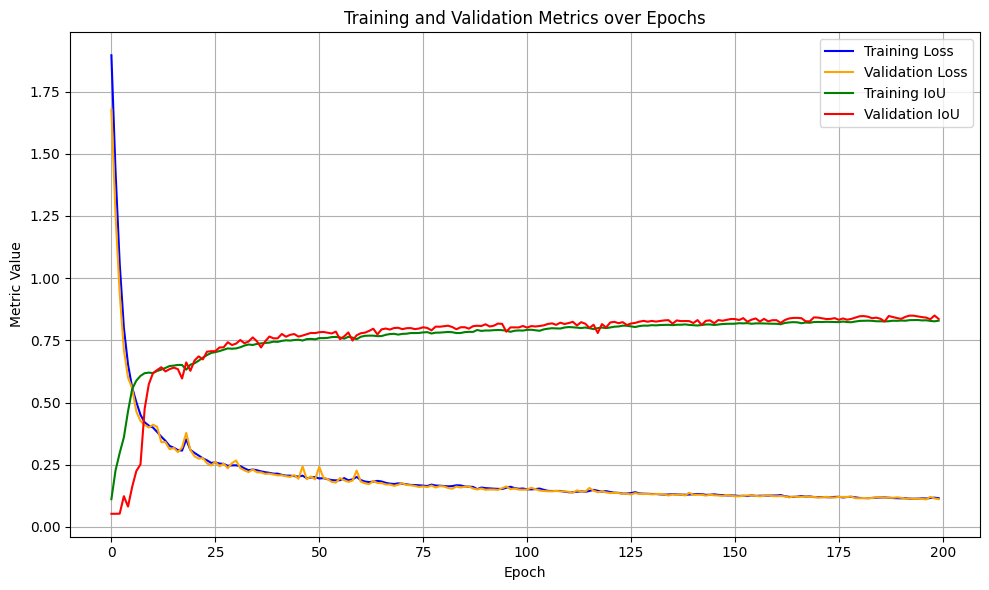

In [40]:
# Step 17: Visualize Training and Validation Metrics
plt.figure(figsize=(10, 6))

# Plotting Training Loss
plt.plot(train_loss_hist, label='Training Loss', color='blue')

# Plotting Validation Loss
plt.plot(val_loss_hist, label='Validation Loss', color='orange')

plt.plot(train_iou_hist, label='Training IoU', color='green')

# Plotting Validation IoU
plt.plot(val_iou_hist, label='Validation IoU', color='red')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [41]:
# Step 18: Save Model Weights
torch.save(model.cpu().state_dict(), model_path)

In [42]:
color_encoding = [
                ('a', (0, 0, 0)),    # Black
                ('b', (255, 0, 0)),  # Red
                ('c', (0, 255, 0)),  # Green
                ('d', (0, 0, 255)),  # Blue
                ('e', (255, 255, 0)),  # Yellow
                ('f', (0, 255, 255))   # Cyan
]

num_classes=7

def label_for_cross_entropy(label):
    """
        Convert label image to matrix classes for apply cross entropy loss.
        Return semantic index, label in enumemap of H x W x class
    """
    semantic_map = np.zeros(label.shape[:-1])
    # Fill all value with class 13 - default for all pixels
    semantic_map.fill(num_classes - 1)
    # Fill the pixel with correct class

    for class_index, color_info in enumerate(color_encoding):
        color = color_info[1]
        equality = np.equal(label, color)
        class_map = np.all(equality, axis=-1)
        semantic_map[class_map] = class_index
    return semantic_map

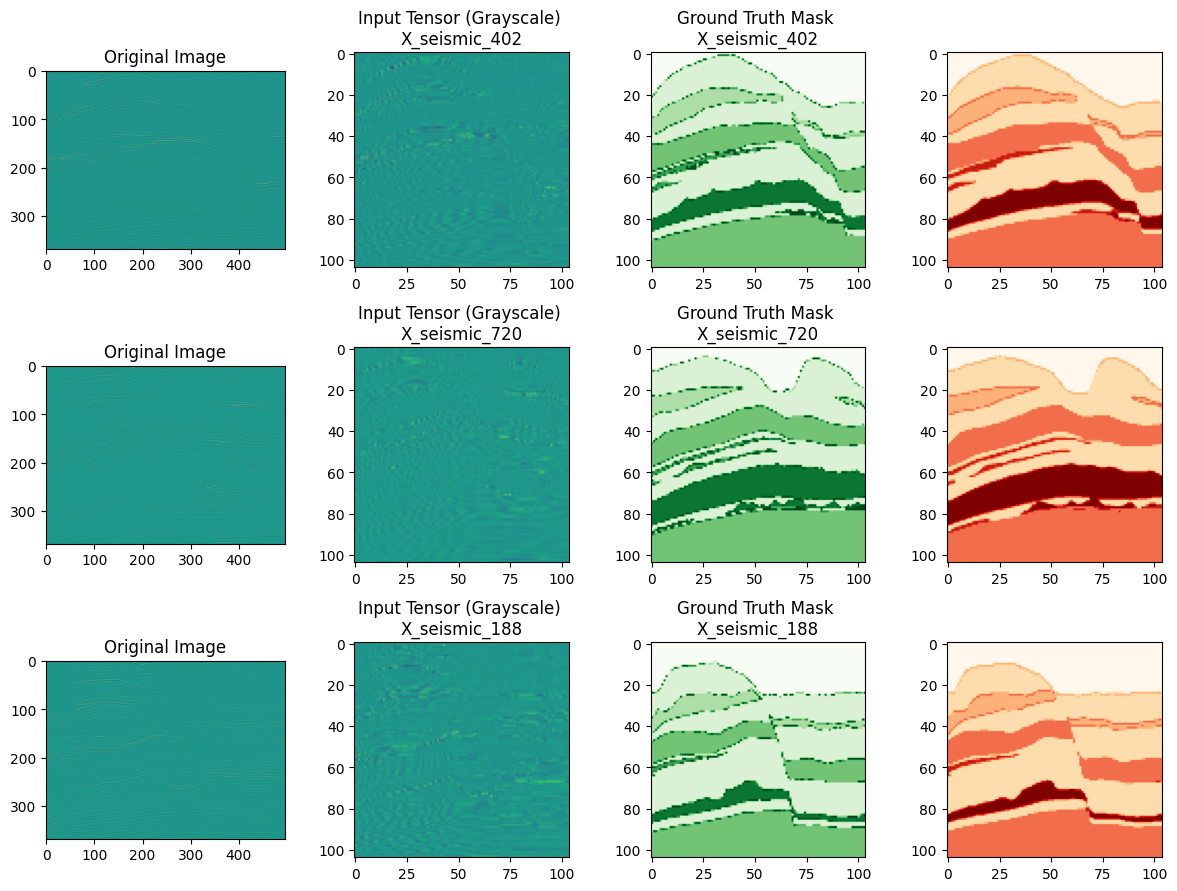

In [43]:
# Step 20: Evaluate Model on Sample Images
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Define the sample image names
names = ['X_seismic_402', 'X_seismic_720', 'X_seismic_188']
names2 = ['X_mask_402', 'X_mask_720', 'X_mask_188']

val_image_path = '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic'
val_mask_path = '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask'

# Load the sample images and masks
images = [Image.open(os.path.join(val_image_path, name+'.png')) for name in names]
images = [i.convert('RGB') for i in images]

masks = [Image.open(os.path.join(val_mask_path, name+'.png')) for name in names2]
masks = [i.convert('RGB') for i in masks]
masks = [np.array(i) for i in masks]
masks = [label_for_cross_entropy(i) for i in masks]
masks = [Image.fromarray(i) for i in masks]

# Apply transformations to convert images to tensors
transforms = T.Compose([T.ToTensor(), T.Resize((104, 104))])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

# Generate predictions using the model
# Assuming 'x' is your input tensor
x = x.to(device)  # Move input tensor to the same device as the model

# Generate predictions using the model
outputs = model(x)
outputs =  outputs.squeeze()

output_temps = outputs 
outputs = np.array(outputs.detach().cpu())

# val_label = val_label.squeeze()
# val_label = np.array(val_label)

# Visualize the sample images, ground truth masks, and model predictions
fig = plt.figure(figsize=(12, 9))
for i in range(len(names)):
    # Plot original image
    ax = fig.add_subplot(3, 4, i*4+1)
    plt.imshow(images[i])
    ax.set_title("Original Image")

    # Plot input tensor
    ax = fig.add_subplot(3, 4, i*4+2)
    # Assuming x is your tensor on a CUDA device (GPU)
    # Move tensor x to CPU and then convert it to a NumPy array
    x_numpy = x[i].squeeze().cpu().numpy()
    
    x_numpy = np.transpose(x_numpy, (1, 2, 0))
    
    ax.imshow(x_numpy.squeeze(), cmap="Greys")
    ax.set_title(f'Input Tensor (Grayscale) \n{names[i]}')

    # Plot ground truth mask
    ax = fig.add_subplot(3, 4, i*4+3)
    ax.imshow(y[i].squeeze(), cmap="Greens")
    ax.set_title(f'Ground Truth Mask \n{names[i]}')
    
    # Plot model prediction
    ax = fig.add_subplot(3, 4, i*4+4)
    # Move tensor from GPU to CPU and then convert it to a NumPy array
    output = outputs[i].squeeze()
    
    # Convert NumPy array to PyTorch tensor
    output_tensor = torch.from_numpy(output)
    
    class_labels = torch.argmax(output_tensor, dim=0)
    class_labels_np = class_labels.cpu().numpy().astype(np.uint8)
    
    ax.imshow(class_labels_np, cmap="OrRd")
#     ax.set_title("Model Prediction\nmIoU: " + str(round(df_sorted[df_sorted['name'] == names[i]]['IoU'].values[0], 3)))

plt.tight_layout()
plt.show()